In [52]:
# loading the json files
import json
import pandas as pd
from pathlib import Path

start = Path.cwd()
data_path = None
for candidate in [start] + list(start.parents):
    candidate_path = candidate / "data/raw/spotify_export"
    if candidate_path.exists():
        data_path = candidate_path
        break
if data_path is None:
    data_path = Path("..\data/raw/spotify_export").resolve()

records = []
files = sorted(data_path.glob("Streaming_History_Audio*.json")) if data_path.exists() else []
for file in files:
    with open(file, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
        except Exception:
            continue
        if isinstance(data, dict):
            for key in ("StreamingHistory", "streaming_history", "items", "sessions"):
                if key in data and isinstance(data[key], list):
                    data = data[key]
                    break
            else:
                lists = [v for v in data.values() if isinstance(v, list)]
                if lists:
                    data = lists[0]
                else:
                    continue
        if isinstance(data, list):
            records.extend(data)

df = pd.DataFrame(records)

In [53]:
# cleaning up column names
df = df.rename(columns={
    "master_metadata_album_artist_name": "artist",
    "master_metadata_track_name": "track",
    "master_metadata_album_album_name": "album",
    "msPlayed": "ms_played"
})

df.columns

Index(['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr', 'track',
       'artist', 'album', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'audiobook_title',
       'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
       'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
       'offline_timestamp', 'incognito_mode'],
      dtype='object')

In [ ]:
#creating time features
df["end_time"] = pd.to_datetime(df["ts"])
df["minutes_played"] = df["ms_played"] / 60000

df["date"] = df["end_time"].dt.date
df["hour"] = df["end_time"].dt.hour
df["weekday"] = df["end_time"].dt.day_name()
df["month"] = df["end_time"].dt.to_period("M").astype(str)

C:\Users\jjada\AppData\Local\Temp\ipykernel_21264\2393170599.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["end_time"].dt.to_period("M").astype(str)


In [ ]:
#filtering out rows with less than 30 seconds of playtime
df = df[df["minutes_played"] > 0.5]

In [ ]:
from pathlib import Path
start = Path.cwd()
processed_dir = None
for candidate in [start] + list(start.parents):
    candidate_path = candidate / "data/processed"
    if candidate_path.exists():
        processed_dir = candidate_path
        break
if processed_dir is None:
    processed_dir = (start / ".." / "data" / "processed").resolve()
processed_dir.mkdir(parents=True, exist_ok=True)
out_path = processed_dir / "listening_history.csv"
df.to_csv(out_path, index=False)
out_path

WindowsPath('c:/Users/jjada/GitHub Portfolio/Spotify Listening Analytics Project/spotify-analytics/data/processed/listening_history.csv')

In [58]:
artist_summary = (
    df.groupby("artist")
    .agg(
        total_minutes=("minutes_played", "sum"),
        play_count=("track", "count")
    )
    .reset_index()
    .sort_values("total_minutes", ascending=False)
)

from pathlib import Path
start = Path.cwd()
processed_dir = None
for candidate in [start] + list(start.parents):
    candidate_path = candidate / "data/processed"
    if candidate_path.exists():
        processed_dir = candidate_path
        break
if processed_dir is None:
    processed_dir = (start / ".." / "data" / "processed").resolve()
processed_dir.mkdir(parents=True, exist_ok=True)
out_path = processed_dir / "artist_summary.csv"
df.to_csv(out_path, index=False)
out_path


WindowsPath('c:/Users/jjada/GitHub Portfolio/Spotify Listening Analytics Project/spotify-analytics/data/processed/artist_summary.csv')

In [59]:
time_summary = (
    df.groupby(["month", "weekday", "hour"])
    .agg(total_minutes=("minutes_played", "sum"))
    .reset_index()
)

from pathlib import Path
start = Path.cwd()
processed_dir = None
for candidate in [start] + list(start.parents):
    candidate_path = candidate / "data/processed"
    if candidate_path.exists():
        processed_dir = candidate_path
        break
if processed_dir is None:
    processed_dir = (start / ".." / "data" / "processed").resolve()
processed_dir.mkdir(parents=True, exist_ok=True)
out_path = processed_dir / "time_features.csv"
df.to_csv(out_path, index=False)
out_path


WindowsPath('c:/Users/jjada/GitHub Portfolio/Spotify Listening Analytics Project/spotify-analytics/data/processed/time_features.csv')

<Axes: xlabel='artist'>

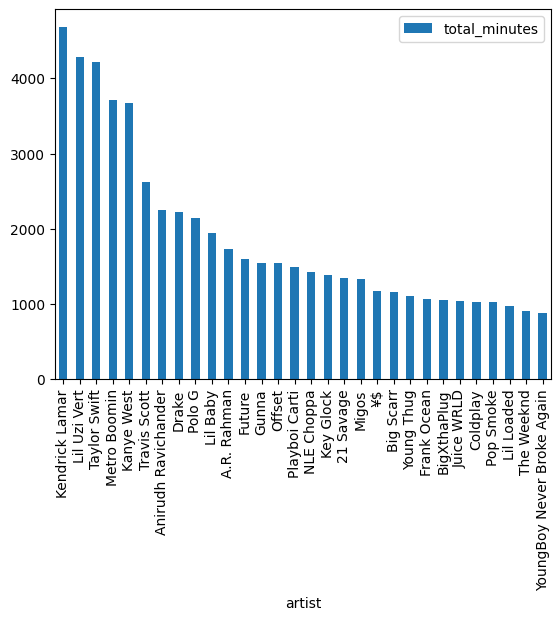

In [64]:
artist_summary.head(30).plot(
    x="artist", y="total_minutes", kind="bar"
)